In [ ]:
!pip uninstall -y cupy-cuda11x cupy-cuda12x cupy


Found existing installation: cupy-cuda12x 13.3.0
Uninstalling cupy-cuda12x-13.3.0:
  Successfully uninstalled cupy-cuda12x-13.3.0


In [ ]:
!pip install cupy-cuda12x

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.2/113.2 MB 7.7 MB/s eta 0:00:00


In [ ]:
!apt-cache search cuda-cusparse


In [ ]:
!nvidia-smi

Tue Aug 12 09:49:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from scipy.optimize import curve_fit

# --- Map and its derivative using CuPy ---
def f_SB(x, b):
    return cp.where(x <= 1 / b, b * x, (b * x - 1) / (b - 1))

def df_SB(x, b):
    return cp.where(x <= 1 / b, b, b / (b - 1))

# --- System evolution using GPU ---
def evolve_system_gpu(N, p, T, epsilon, b, seed):
    rng = np.random.default_rng(seed)

    # Graph on CPU, adjacency matrix as NumPy
    G = nx.erdos_renyi_graph(N, p, seed=rng, directed=False)
    A_cpu = nx.adjacency_matrix(G).astype(np.float32)
    A_cpu.setdiag(1.0)
    A_cpu = A_cpu.tocsr()

    deg = np.array(A_cpu.sum(axis=1)).flatten()
    deg_safe = np.where(deg == 0, 1, deg)

    # Move CPU matrix to CuPy sparse (CSR format)
    A_gpu = cp.sparse.csr_matrix(A_cpu)
    deg_safe_gpu = cp.asarray(deg_safe)

    y = cp.asarray(rng.uniform(0, 1, N), dtype=cp.float32)
    v = cp.asarray(rng.uniform(-1e-8, 1e-8, N), dtype=cp.float32)

    le_sum = 0.0
    for _ in range(T):
        local = f_SB(y, b)
        coupling = A_gpu @ local / deg_safe_gpu
        y = (1 - epsilon) * local + epsilon * coupling

        J = df_SB(y, b)
        v = (1 - epsilon) * J * v + epsilon * (A_gpu @ (J * v) / deg_safe_gpu)

        v_norm = cp.linalg.norm(v)
        if v_norm == 0:
            continue
        le_sum += cp.log(cp.abs(v_norm))
        v /= v_norm

    return float(le_sum / T)

Processing λ for different N: 100%|██████████| 4/4 [38:30<00:00, 577.62s/it]


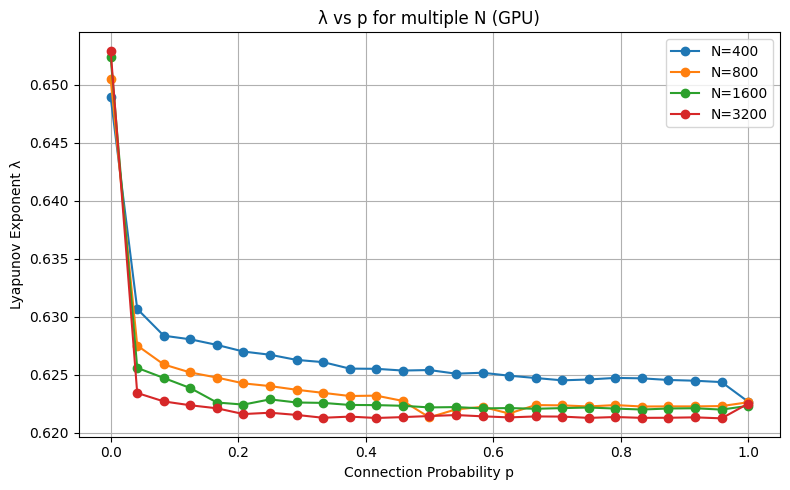

Computing γ vs p: 100%|██████████| 25/25 [00:00<00:00, 85.38it/s]


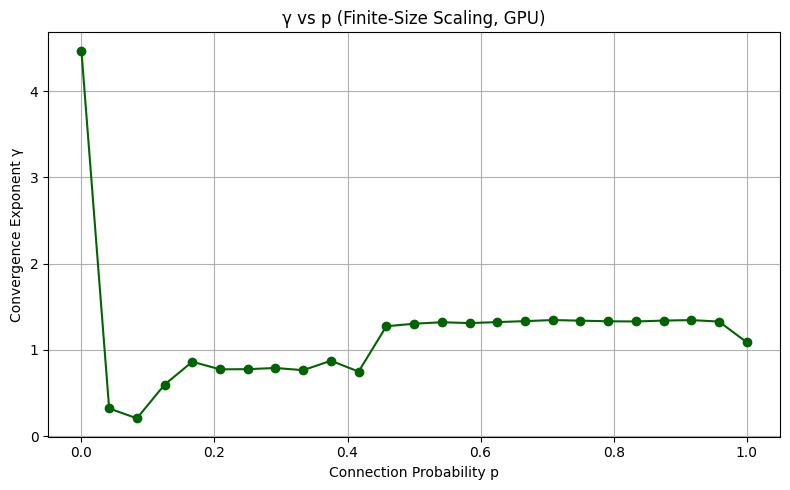

In [ ]:


# --- Compute λ vs p for a fixed N (no multiprocessing, runs serially) ---
def compute_LE_vs_p_gpu(N, T, epsilon, b, p_values, n_trials=4):
    avg_LEs = []
    for p in tqdm(p_values, desc=f"Computing λ for N={N}", leave=False):
        seeds = np.arange(n_trials) + 100
        results = [evolve_system_gpu(N, p, T, epsilon, b, seed) for seed in seeds]
        avg_LEs.append(np.mean(results))
    return np.array(p_values), np.array(avg_LEs)

# --- Fit function for gamma ---
def power_law(N, lambda_inf, A, gamma):
    return lambda_inf + A * N**(-gamma)

# --- Compute γ vs p using λ from multiple N ---
def compute_gamma_vs_p(N_list, all_lambdas, p_values):
    gammas = []
    for i, p in enumerate(tqdm(p_values, desc="Computing γ vs p")):
        lambdas_p = [lambdas[i] for lambdas in all_lambdas]
        try:
            popt, _ = curve_fit(power_law, N_list, lambdas_p,
                                bounds=([-1, -10, 0.01], [1, 10, 5]))
            gamma = popt[2]
        except Exception:
            gamma = np.nan
        gammas.append(gamma)
    return np.array(gammas)

# --- Parameters ---
T = 1000
epsilon = 0.3
b = 1.5
p_values = np.linspace(0.0, 1.0, 25)
N_list = [400, 800, 1600, 3200]

# --- Main run ---
all_lambdas = []
plt.figure(figsize=(8, 5))
for N in tqdm(N_list, desc="Processing λ for different N"):
    _, lambdas = compute_LE_vs_p_gpu(N, T, epsilon, b, p_values)
    all_lambdas.append(lambdas)
    plt.plot(p_values, lambdas, marker='o', label=f'N={N}')

plt.xlabel("Connection Probability p")
plt.ylabel("Lyapunov Exponent λ")
plt.title("λ vs p for multiple N (GPU)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- γ vs p ---
gamma_values = compute_gamma_vs_p(N_list, all_lambdas, p_values)

plt.figure(figsize=(8, 5))
plt.plot(p_values, gamma_values, marker='o', color='darkgreen')
plt.xlabel("Connection Probability p")
plt.ylabel("Convergence Exponent γ")
plt.title("γ vs p (Finite-Size Scaling, GPU)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# --- Save results to file ---
np.savez_compressed("le_gamma_results_eps03.npz",
                    p_values=p_values,
                    N_list=N_list,
                    all_lambdas=np.array(all_lambdas),
                    gamma_values=gamma_values)


Processing λ for different N: 100%|██████████| 4/4 [38:14<00:00, 573.65s/it]


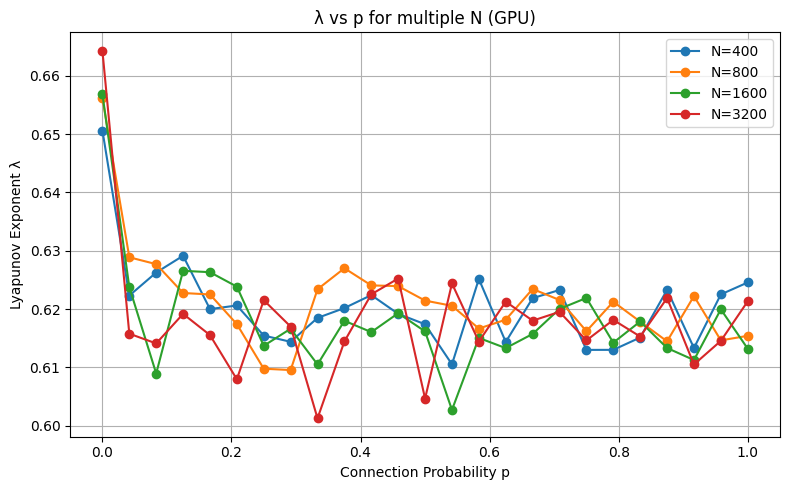

Computing γ vs p: 100%|██████████| 25/25 [00:00<00:00, 43.44it/s]


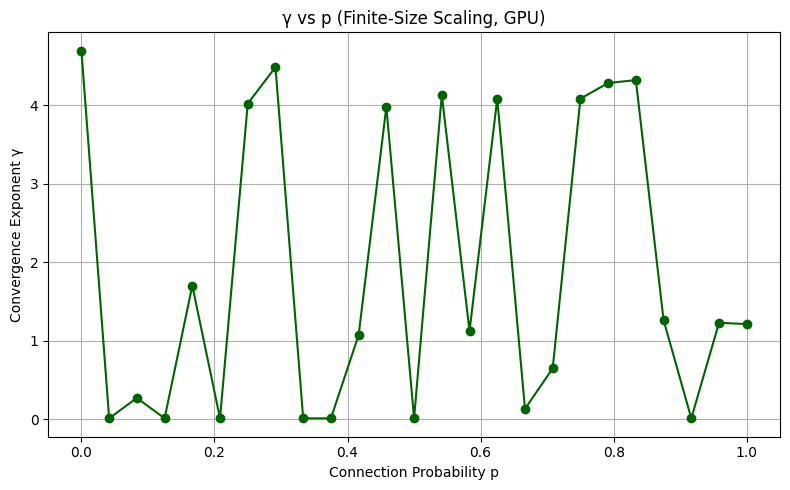

In [ ]:
epsilon = 0.6
b = 1.5
p_values = np.linspace(0.0, 1.0, 25)
N_list = [400, 800, 1600, 3200]

# --- Main run ---
all_lambdas = []
plt.figure(figsize=(8, 5))
for N in tqdm(N_list, desc="Processing λ for different N"):
    _, lambdas = compute_LE_vs_p_gpu(N, T, epsilon, b, p_values)
    all_lambdas.append(lambdas)
    plt.plot(p_values, lambdas, marker='o', label=f'N={N}')

plt.xlabel("Connection Probability p")
plt.ylabel("Lyapunov Exponent λ")
plt.title("λ vs p for multiple N (GPU)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- γ vs p ---
gamma_values = compute_gamma_vs_p(N_list, all_lambdas, p_values)

plt.figure(figsize=(8, 5))
plt.plot(p_values, gamma_values, marker='o', color='darkgreen')
plt.xlabel("Connection Probability p")
plt.ylabel("Convergence Exponent γ")
plt.title("γ vs p (Finite-Size Scaling, GPU)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
np.savez_compressed("le_gamma_results_eps06.npz",
                    p_values=p_values,
                    N_list=N_list,
                    all_lambdas=np.array(all_lambdas),
                    gamma_values=gamma_values)


Processing λ for different N: 100%|██████████| 4/4 [37:51<00:00, 567.80s/it]


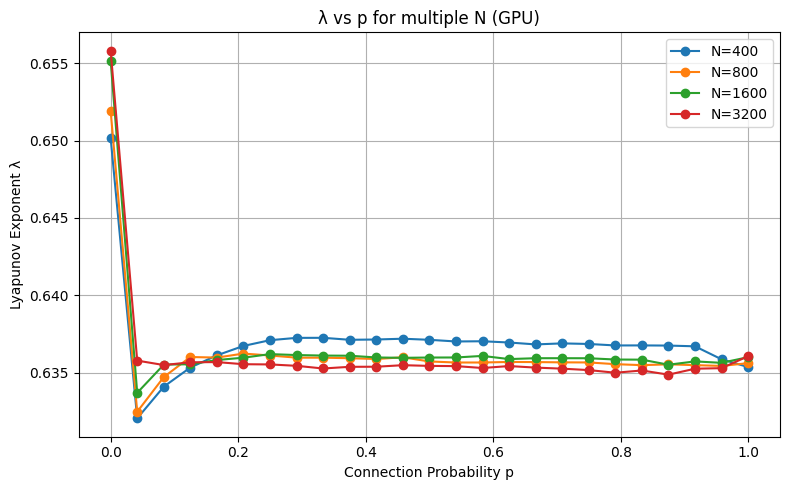

Computing γ vs p: 100%|██████████| 25/25 [00:00<00:00, 90.59it/s]


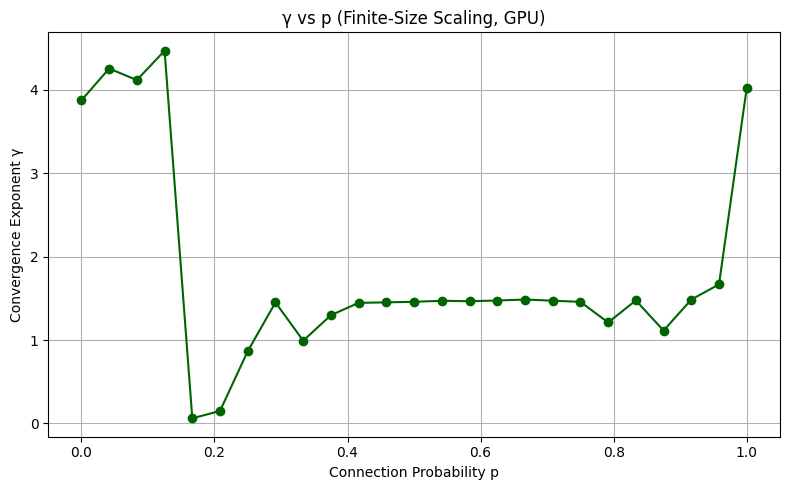

In [ ]:
epsilon = 0.43
b = 1.5
p_values = np.linspace(0.0, 1.0, 25)
N_list = [400, 800, 1600, 3200]

# --- Main run ---
all_lambdas = []
plt.figure(figsize=(8, 5))
for N in tqdm(N_list, desc="Processing λ for different N"):
    _, lambdas = compute_LE_vs_p_gpu(N, T, epsilon, b, p_values)
    all_lambdas.append(lambdas)
    plt.plot(p_values, lambdas, marker='o', label=f'N={N}')

plt.xlabel("Connection Probability p")
plt.ylabel("Lyapunov Exponent λ")
plt.title("λ vs p for multiple N (GPU)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- γ vs p ---
gamma_values = compute_gamma_vs_p(N_list, all_lambdas, p_values)

plt.figure(figsize=(8, 5))
plt.plot(p_values, gamma_values, marker='o', color='darkgreen')
plt.xlabel("Connection Probability p")
plt.ylabel("Convergence Exponent γ")
plt.title("γ vs p (Finite-Size Scaling, GPU)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
np.savez_compressed("le_gamma_results_eps043.npz",
                    p_values=p_values,
                    N_list=N_list,
                    all_lambdas=np.array(all_lambdas),
                    gamma_values=gamma_values)


Processing λ for different N: 100%|██████████| 4/4 [37:36<00:00, 564.03s/it]


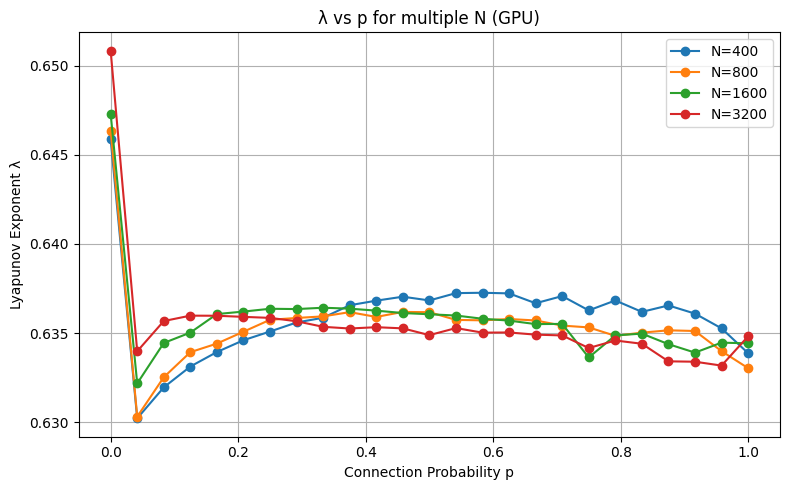

Computing γ vs p: 100%|██████████| 25/25 [00:00<00:00, 37.34it/s]


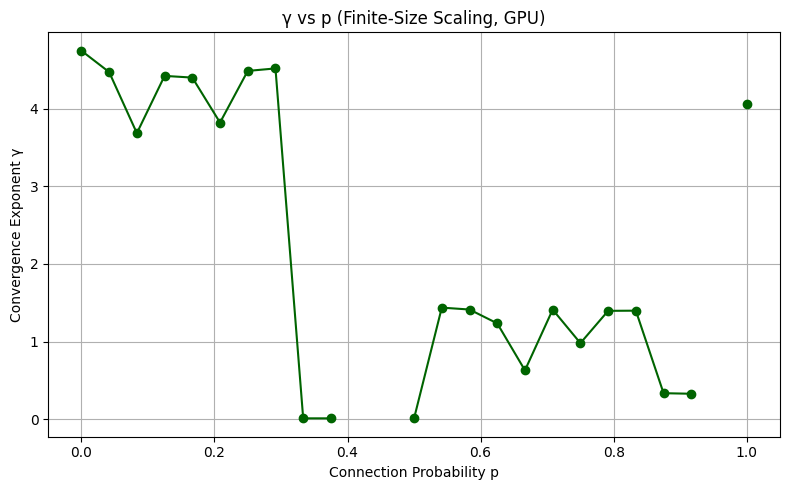

In [ ]:
epsilon = 0.45
b = 1.5
p_values = np.linspace(0.0, 1.0, 25)
N_list = [400, 800, 1600, 3200]

# --- Main run ---
all_lambdas = []
plt.figure(figsize=(8, 5))
for N in tqdm(N_list, desc="Processing λ for different N"):
    _, lambdas = compute_LE_vs_p_gpu(N, T, epsilon, b, p_values)
    all_lambdas.append(lambdas)
    plt.plot(p_values, lambdas, marker='o', label=f'N={N}')

plt.xlabel("Connection Probability p")
plt.ylabel("Lyapunov Exponent λ")
plt.title("λ vs p for multiple N (GPU)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- γ vs p ---
gamma_values = compute_gamma_vs_p(N_list, all_lambdas, p_values)

plt.figure(figsize=(8, 5))
plt.plot(p_values, gamma_values, marker='o', color='darkgreen')
plt.xlabel("Connection Probability p")
plt.ylabel("Convergence Exponent γ")
plt.title("γ vs p (Finite-Size Scaling, GPU)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
np.savez_compressed("le_gamma_results_eps045.npz",
                    p_values=p_values,
                    N_list=N_list,
                    all_lambdas=np.array(all_lambdas),
                    gamma_values=gamma_values)

In [ ]:


def simulate_y_trajectories_gpu(N, p, T, epsilon, b, seed=0):
    rng = np.random.default_rng(seed)
    # Build graph and adjacency matrix on CPU
    G = nx.erdos_renyi_graph(N, p, seed=seed, directed=False)
    A_cpu = nx.adjacency_matrix(G).astype(np.float32)
    A_cpu.setdiag(1.0)
    A_cpu = A_cpu.tocsr()

    deg = np.array(A_cpu.sum(axis=1)).flatten()
    deg_safe = np.where(deg == 0, 1, deg)

    # Move to GPU
    A_gpu = cp.sparse.csr_matrix(A_cpu)
    deg_safe_gpu = cp.asarray(deg_safe)

    y = cp.asarray(rng.uniform(0, 1, N), dtype=cp.float32)
    y_history = cp.zeros((T, N), dtype=cp.float32)

    for t in range(T):
        local = f_SB(y, b)
        coupling = A_gpu @ local / deg_safe_gpu
        y = (1 - epsilon) * local + epsilon * coupling
        y_history[t] = y

    # Move back to CPU
    return cp.asnumpy(y_history)


In [ ]:
def compute_synchrony_r(y_history):
    # y_history shape (T, N)
    # Convert each y_i to phase on unit circle
    phases = np.exp(2j * np.pi * y_history)
    r_t = np.abs(np.mean(phases, axis=1))
    return r_t


In [ ]:
def ensemble_r_gpu(epsilon, N, p, T, b=4.0, trials=10, seed0=0):
    all_r = []
    for tr in range(trials):
        y_hist = simulate_y_trajectories_gpu(N=N, p=p, T=T, epsilon=epsilon, b=b, seed=seed0+tr)
        r = compute_synchrony_r(y_hist)
        all_r.append(r)
    all_r = np.array(all_r)
    return all_r.mean(axis=0), all_r.std(axis=0)


In [ ]:
import pandas as pd
from scipy.ndimage import uniform_filter1d

def smooth(x, window=21):
    if window <= 1:
        return x
    return uniform_filter1d(x, size=window, mode='reflect')

def r_stats(r, burn=100):
    r_post = r[burn:]
    return {
        'r_mean': np.mean(r_post),
        'r_std': np.std(r_post),
        'r_max': np.max(r_post),
        'r_min': np.min(r_post),
        'r_median': np.median(r_post),
        'r_q25': np.percentile(r_post, 25),
        'r_q75': np.percentile(r_post, 75),
    }

def percent_time_above(r, thresh=0.2, burn=100):
    r_post = r[burn:]
    return np.mean(r_post > thresh)

def sweep_analyze_gpu(epsilon_list, N, p, T=1000, b=4.0,
                      trials=5, smooth_win=21, burn=100, thresh=0.2, seed0=0):
    rows = []
    r_matrix = []

    for eps in epsilon_list:
        r_mean_t, r_std_t = ensemble_r_gpu(eps, N, p, T, b, trials, seed0)
        r_smooth = smooth(r_mean_t, window=smooth_win)
        r_matrix.append(r_smooth)

        stats = r_stats(r_smooth, burn)
        pct = percent_time_above(r_smooth, thresh, burn)
        stats.update({
            'epsilon': eps,
            'pct_above_thresh': pct,
            'r_time_series_mean': np.mean(r_smooth),
            'r_std': np.std(r_smooth[burn:]),
        })
        rows.append(stats)

    df = pd.DataFrame(rows).set_index('epsilon')
    r_matrix = np.array(r_matrix)
    return df, r_matrix


In [ ]:
def plot_mean_vs_eps(df):
    plt.figure(figsize=(8,4))
    plt.errorbar(df.index, df['r_time_series_mean'], yerr=df['r_std'], fmt='-o', capsize=3)
    plt.xlabel('Epsilon')
    plt.ylabel('Mean r (smoothed)')
    plt.title('Mean Synchrony vs Epsilon (Sparse GPU system)')
    plt.grid(True)
    plt.show()


In [ ]:
# Parameters
N = 800
p = 0.2           # connection probability in Erdős–Rényi graph
T = 1000
b = 4.0
trials = 5
smooth_win = 21
burn = 100
thresh = 0.2

epsilon_list = np.linspace(0, 0.5, 51)

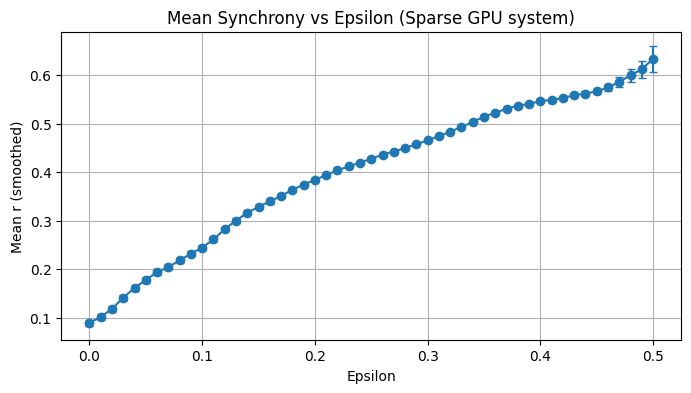

In [ ]:

df, r_matrix = sweep_analyze_gpu(epsilon_list, N, p, T, b, trials, smooth_win, burn, thresh)

plot_mean_vs_eps(df)


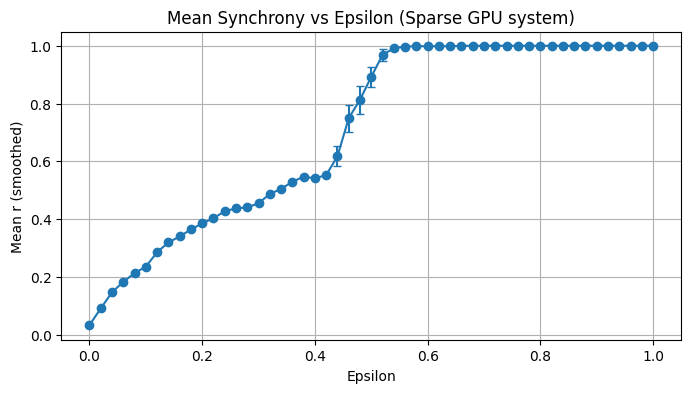

In [ ]:
p = 0.2
epsilon_list = np.linspace(0, 1, 51)

df, r_matrix = sweep_analyze_gpu(epsilon_list, N, p, T, b, trials, smooth_win, burn, thresh)

plot_mean_vs_eps(df)

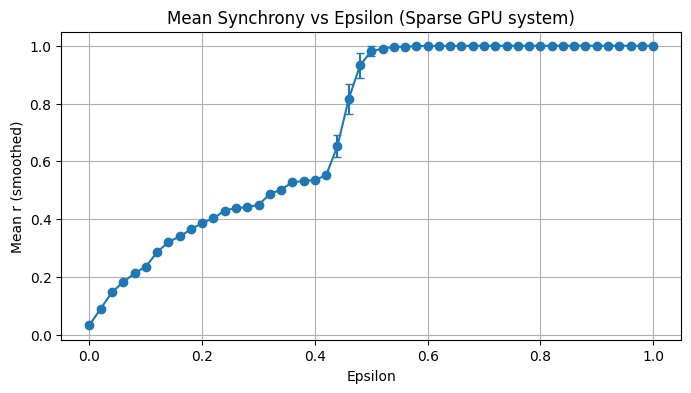

In [ ]:
p = 0.45
epsilon_list = np.linspace(0, 1, 51)

df2, r_matrix2 = sweep_analyze_gpu(epsilon_list, N, p, T, b, trials, smooth_win, burn, thresh)

plot_mean_vs_eps(df2)

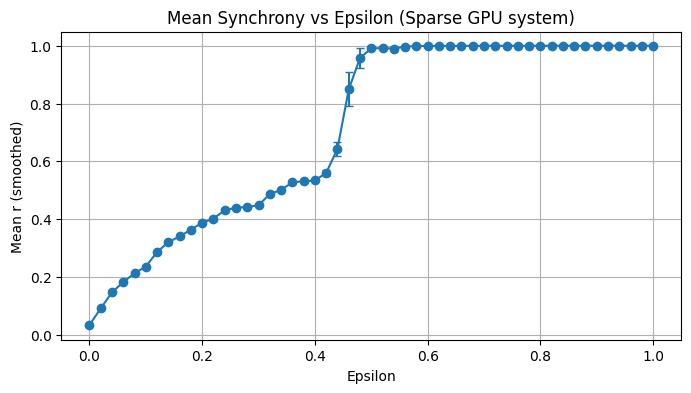

In [ ]:
p = 0.7
epsilon_list = np.linspace(0, 1, 51)

df3, r_matrix3 = sweep_analyze_gpu(epsilon_list, N, p, T, b, trials, smooth_win, burn, thresh)

plot_mean_vs_eps(df3)

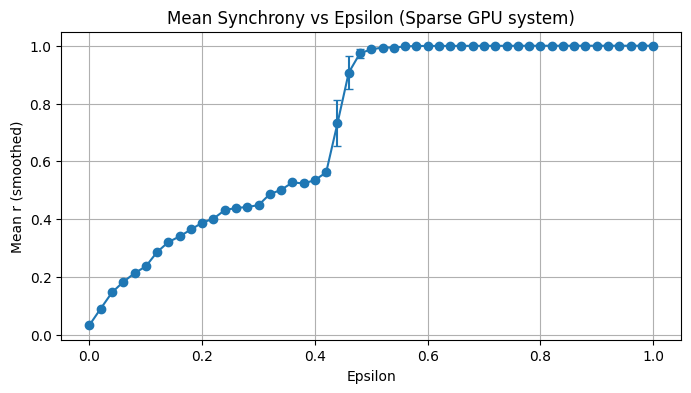

In [ ]:
p = 0.95
epsilon_list = np.linspace(0, 1, 51)

df, r_matrix = sweep_analyze_gpu(epsilon_list, N, p, T, b, trials, smooth_win, burn, thresh)

plot_mean_vs_eps(df)

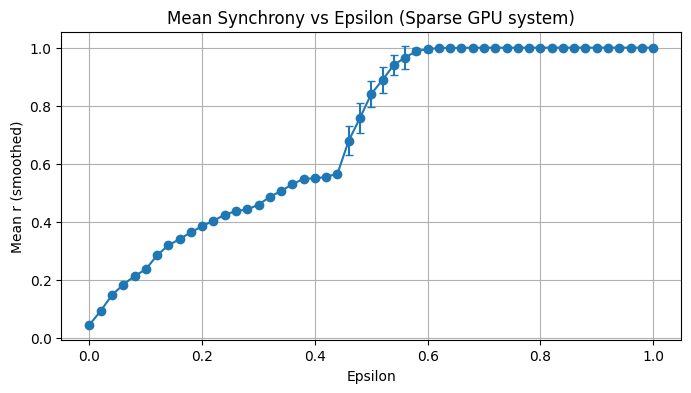

In [ ]:
N= 400
p = 0.2
epsilon_list = np.linspace(0, 1, 51)

df, r_matrix = sweep_analyze_gpu(epsilon_list, N, p, T, b, trials, smooth_win, burn, thresh)

plot_mean_vs_eps(df)

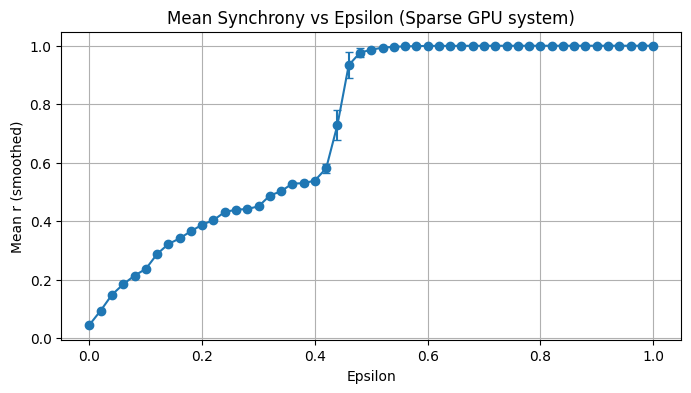

In [ ]:
p = 1
epsilon_list = np.linspace(0, 1, 51)

df, r_matrix = sweep_analyze_gpu(epsilon_list, N, p, T, b, trials, smooth_win, burn, thresh)

plot_mean_vs_eps(df)

In [ ]:
import plotly.express as px
from scipy.ndimage import uniform_filter1d
import os

In [ ]:
# --- Simulate GPU sparse coupled map and save full history ---
def simulate_y_trajectories_gpu_full(N, p, T, epsilon, b, seed):
    rng = np.random.default_rng(seed)
    G = nx.erdos_renyi_graph(N, p, seed=seed, directed=False)
    A_cpu = nx.adjacency_matrix(G).astype(np.float32)
    A_cpu.setdiag(1.0)
    A_cpu = A_cpu.tocsr()

    deg = np.array(A_cpu.sum(axis=1)).flatten()
    deg_safe = np.where(deg == 0, 1, deg)

    A_gpu = cp.sparse.csr_matrix(A_cpu)
    deg_safe_gpu = cp.asarray(deg_safe)

    y = cp.asarray(rng.uniform(0, 1, N), dtype=cp.float32)
    y_history = cp.zeros((T, N), dtype=cp.float32)

    for t in range(T):
        local = f_SB(y, b)
        coupling = A_gpu @ local / deg_safe_gpu
        y = (1 - epsilon) * local + epsilon * coupling
        y_history[t] = y

    return cp.asnumpy(y_history)

# --- Compute synchrony r(t) ---
def compute_synchrony_r(y_history):
    phases = np.exp(2j * np.pi * y_history)
    r_t = np.abs(np.mean(phases, axis=1))
    return r_t

# --- Smooth function ---
def smooth(x, window=21):
    if window <= 1:
        return x
    return uniform_filter1d(x, size=window, mode='reflect')

# --- Ensemble average for one (epsilon, p) ---
def ensemble_mean_r(N, p, T, epsilon, b=4.0, trials=3, seed0=0, smooth_win=21):
    all_r = []
    for tr in range(trials):
        y_hist = simulate_y_trajectories_gpu_full(N, p, T, epsilon, b, seed=seed0+tr)
        r_t = compute_synchrony_r(y_hist)
        r_smooth = smooth(r_t, window=smooth_win)
        all_r.append(r_smooth)
    all_r = np.array(all_r)
    mean_r = all_r.mean(axis=0)
    return mean_r

# --- Main sweep function ---

def sweep_eps_p(N, T, b, trials, smooth_win):
    epsilon_vals = np.linspace(0, 0.5, 51)
    p_vals = np.linspace(0, 1.0, 51)

    Z = np.zeros((len(p_vals), len(epsilon_vals)))

    for i, p in enumerate(p_vals):
        for j, eps in enumerate(epsilon_vals):
            mean_r = ensemble_mean_r(N, p, T, eps, b, trials, seed0=i*1000+j, smooth_win=smooth_win)
            Z[i, j] = mean_r.mean()  # mean over time of r(t)
            print(f"Done p={p:.3f}, eps={eps:.3f}, mean r={Z[i,j]:.4f}")

    # Save the result
    np.savez("synchrony_data2.npz", Z=Z, epsilon_vals=epsilon_vals, p_vals=p_vals)
    print("Data saved to synchrony_data2.npz")

    return epsilon_vals, p_vals, Z
# --- Run sweep and plot ---
def run_and_plot():
    N = 100
    T = 1000
    b = 4.0
    trials = 3  # reduce for speed
    smooth_win = 21

    epsilons, ps, Z = sweep_eps_p(N, T, b, trials, smooth_win)

    fig = px.imshow(
        Z,
        x=np.round(epsilons, 3),
        y=np.round(ps, 3),
        labels={'x': 'Epsilon', 'y': 'Connection Probability p', 'color': 'Mean Synchrony'},
        aspect='auto',
        title='Mean Synchrony vs Epsilon and Connection Probability p'
    )
    fig.update_layout(yaxis=dict(autorange='reversed'))  # flip y-axis so p=0 at bottom
    fig.show()

if __name__ == "__main__":
    run_and_plot()

Done p=0.000, eps=0.000, mean r=0.0906
Done p=0.000, eps=0.020, mean r=0.0884
Done p=0.000, eps=0.040, mean r=0.0887
Done p=0.000, eps=0.060, mean r=0.0873
Done p=0.000, eps=0.080, mean r=0.0890
Done p=0.000, eps=0.100, mean r=0.0894
Done p=0.000, eps=0.120, mean r=0.0894
Done p=0.000, eps=0.140, mean r=0.0910
Done p=0.000, eps=0.160, mean r=0.0904
Done p=0.000, eps=0.180, mean r=0.1003
Done p=0.000, eps=0.200, mean r=0.0874
Done p=0.000, eps=0.220, mean r=0.0890
Done p=0.000, eps=0.240, mean r=0.0900
Done p=0.000, eps=0.260, mean r=0.0955
Done p=0.000, eps=0.280, mean r=0.0922
Done p=0.000, eps=0.300, mean r=0.0907
Done p=0.000, eps=0.320, mean r=0.0893
Done p=0.000, eps=0.340, mean r=0.1023
Done p=0.000, eps=0.360, mean r=0.0951
Done p=0.000, eps=0.380, mean r=0.0894
Done p=0.000, eps=0.400, mean r=0.0938
Done p=0.000, eps=0.420, mean r=0.0907
Done p=0.000, eps=0.440, mean r=0.0904
Done p=0.000, eps=0.460, mean r=0.0934
Done p=0.000, eps=0.480, mean r=0.0885
Done p=0.000, eps=0.500, 

In [ ]:
import os

def sweep_eps_p(N, T, b, trials, smooth_win):
    epsilon_vals = np.linspace(0, 0.5, 51)
    p_vals = np.linspace(0, 1.0, 51)

    Z = np.zeros((len(p_vals), len(epsilon_vals)))

    for i, p in enumerate(p_vals):
        for j, eps in enumerate(epsilon_vals):
            mean_r = ensemble_mean_r(N, p, T, eps, b, trials, seed0=i*1000+j, smooth_win=smooth_win)
            Z[i, j] = mean_r.mean()  # mean over time of r(t)
            print(f"Done p={p:.3f}, eps={eps:.3f}, mean r={Z[i,j]:.4f}")

    # Save the result
    np.savez("synchrony_data.npz", Z=Z, epsilon_vals=epsilon_vals, p_vals=p_vals)
    print("Data saved to synchrony_data.npz")

    return epsilon_vals, p_vals, Z

def load_and_plot(filename="synchrony_data.npz"):
    data = np.load(filename)
    Z = data['Z']
    epsilon_vals = data['epsilon_vals']
    p_vals = data['p_vals']

    import plotly.express as px
    fig = px.imshow(
        Z,
        x=np.round(epsilon_vals, 3),
        y=np.round(p_vals, 3),
        labels={'x': 'Epsilon', 'y': 'Connection Probability p', 'color': 'Mean Synchrony'},
        aspect='auto',
        title='Mean Synchrony vs Epsilon and Connection Probability p (Loaded Data)'
    )
    fig.update_layout(yaxis=dict(autorange='reversed'))
    fig.show()


In [ ]:
load_and_plot("synchrony_data.npz")


FileNotFoundError: [Errno 2] No such file or directory: 'synchrony_data.npz'

In [ ]:
p = 0.9
epsilon_list = np.linspace(0, 1, 51)

df, r_matrix = sweep_analyze_gpu(epsilon_list, N, p, T, b, trials, smooth_win, burn, thresh)

plot_mean_vs_eps(df)

Processing λ for different N:   0%|          | 0/4 [00:00<?, ?it/s]/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

Processing λ for different N: 100%|██████████| 4/4 [25:08<00:00, 377.03s/it]


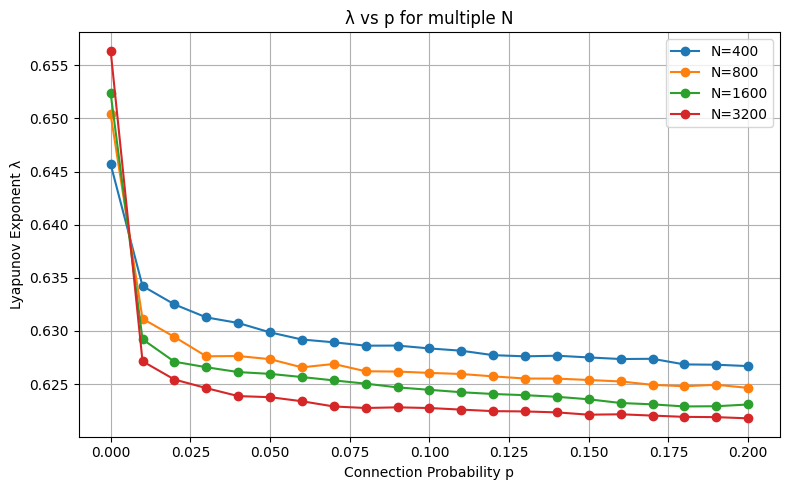

Computing γ vs p: 100%|██████████| 21/21 [00:00<00:00, 29.01it/s]


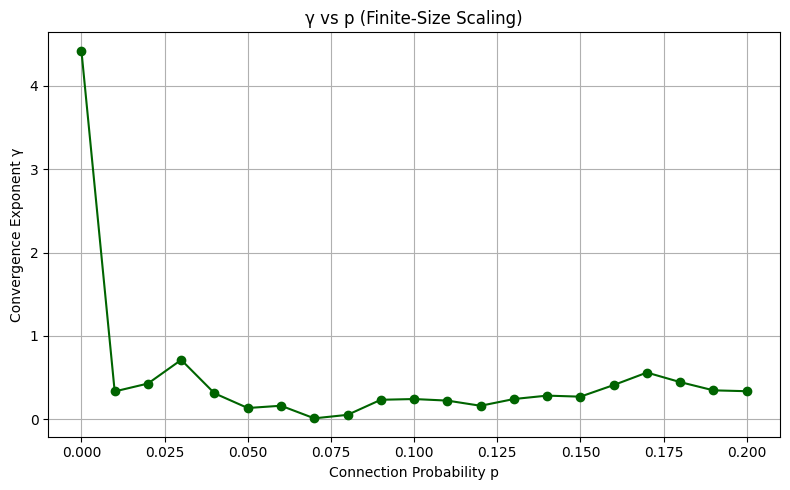

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from multiprocessing import Pool
from functools import partial
from tqdm import tqdm
from scipy.optimize import curve_fit

# --- Map and its derivative ---
def f_SB(x, b):
    return np.where(x <= 1 / b, b * x, (b * x - 1) / (b - 1))

def df_SB(x, b):
    return np.where(x <= 1 / b, b, b / (b - 1))

# --- System evolution ---
def evolve_system(N, p, T, epsilon, b, seed):
    rng = np.random.default_rng(seed)
    G = nx.erdos_renyi_graph(N, p, seed=rng, directed=False)
    A = nx.adjacency_matrix(G).astype(float)
    A.setdiag(1.0)  # Add self-loops
    A = A.tocsr()

    deg = np.array(A.sum(axis=1)).flatten()
    deg_safe = np.where(deg == 0, 1, deg)

    y = rng.uniform(0, 1, N)
    v = rng.uniform(-1e-8, 1e-8, N)

    le_sum = 0.0
    for _ in range(T):
        local = f_SB(y, b)
        coupling = A @ local / deg_safe
        y = (1 - epsilon) * local + epsilon * coupling

        J = df_SB(y, b)
        v = (1 - epsilon) * J * v + epsilon * (A @ (J * v) / deg_safe)

        v_norm = np.linalg.norm(v)
        if v_norm == 0:
            continue
        le_sum += np.log(np.abs(v_norm))
        v /= v_norm

    return le_sum / T

# --- Compute λ vs p for a fixed N ---
def compute_LE_vs_p(N, T, epsilon, b, p_values, n_trials=6):
    avg_LEs = []
    with Pool() as pool:
        for p in tqdm(p_values, desc=f"Computing λ for N={N}", leave=False):
            seeds = np.arange(n_trials) + 100
            func = partial(evolve_system, N, p, T, epsilon, b)
            results = pool.map(func, seeds)
            avg_LEs.append(np.mean(results))
    return np.array(p_values), np.array(avg_LEs)

# --- Fit function for gamma ---
def power_law(N, lambda_inf, A, gamma):
    return lambda_inf + A * N**(-gamma)

# --- Compute γ vs p using λ from multiple N ---
def compute_gamma_vs_p(N_list, all_lambdas, p_values):
    gammas = []
    for i, p in enumerate(tqdm(p_values, desc="Computing γ vs p")):
        lambdas_p = [lambdas[i] for lambdas in all_lambdas]
        try:
            popt, _ = curve_fit(power_law, N_list, lambdas_p, bounds=([-1, -10, 0.01], [1, 10, 5]))
            gamma = popt[2]
        except:
            gamma = np.nan  # If fit fails
        gammas.append(gamma)
    return np.array(gammas)

# --- Parameters ---
T = 1000
epsilon = 0.3
b = 1.5
p_values = np.linspace(0.0, 0.2, 21)
N_list = [400, 800, 1600, 3200]

# --- Main run ---
all_lambdas = []
plt.figure(figsize=(8, 5))
for N in tqdm(N_list, desc="Processing λ for different N"):
    _, lambdas = compute_LE_vs_p(N, T, epsilon, b, p_values)
    all_lambdas.append(lambdas)
    plt.plot(p_values, lambdas, marker='o', label=f'N={N}')

plt.xlabel("Connection Probability p")
plt.ylabel("Lyapunov Exponent λ")
plt.title("λ vs p for multiple N")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- γ vs p ---
gamma_values = compute_gamma_vs_p(N_list, all_lambdas, p_values)

plt.figure(figsize=(8, 5))
plt.plot(p_values, gamma_values, marker='o', color='darkgreen')
plt.xlabel("Connection Probability p")
plt.ylabel("Convergence Exponent γ")
plt.title("γ vs p (Finite-Size Scaling)")
plt.grid(True)
plt.tight_layout()
plt.show()
